In [85]:
import pandas as pd
import numpy as np
from copy import deepcopy
import os
import sys
from importlib import reload
from scipy.stats import zscore
import scipy.io
from scipy.interpolate import make_interp_spline, BSpline
from scipy.signal import savgol_filter as savgol 
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import leidenalg
import umap
import time
import gget
from sklearn import preprocessing

from pydmd import DMD

import matplotlib.pyplot as plt
import seaborn as sns

# local imports
sys.path.append("../python/")

import utils as ut
reload(ut)

import hasnain_DMD
reload(hasnain_DMD)

<module 'hasnain_DMD' from '/home/cstansbu/git_repositories/DMD_gene/notebooks/../python/hasnain_DMD.py'>

In [59]:
# raw_path = f"/nfs/turbo/umms-indikar/shared/projects/time_series_rna/chen2015/RNA_pipeline_ouputs/chen2015_rna/countMatrix/counts.raw.txt"
raw_path = f"/nfs/turbo/umms-indikar/shared/projects/time_series_rna/chen2015/RNA_pipeline_ouputs/chen2015_rna/countMatrix/counts.normalized.txt"


""" Load the raw expression """
df = pd.read_csv(raw_path, index_col=0)
print(f"{df.shape=}")
df.head()

gene_names = df.index.to_list()

df.shape=(19393, 18)


In [64]:
# build fold-change dataframe

def getFCFrame(df, cols):
    """A function to return a new dataframe with 
    foldchanges over the initial. Expects cols to be time-ordered
    and that cols[0] is the initial condition """
    df2 = df[cols].copy()

    x0 = cols[0] # initial condition
    
    for c in cols[1:]:
        df2[c] = (df2[c] + 1) /  (df2[x0] + 1)

    return df2[cols[1:]].copy()

def data2DMD(df):
    """A function to make DMD suitable data from the 2015 data"""
    a = [x for x in df.columns if "a" in x]
    b = [x for x in df.columns if "b" in x]

    dfa = getFCFrame(df, a)
    dfb = getFCFrame(df, b)

    dmd_data = np.asarray([dfa, dfb])
    dmd_data = np.swapaxes(dmd_data, 0, 2)
    dmd_data = np.swapaxes(dmd_data, 0, 1)

    return dmd_data


def getMuData(df):
    """A function to get the mean expression of each replicate at
    each time point """

    mu_data = df.copy()
    mu_data = mu_data.T

    mu_data = mu_data.reset_index(drop=False)
    mu_data['time'] = mu_data['index'].apply(lambda x: x.replace("a", "").replace("b", "").replace('S', ''))
    mu_data['time'] = mu_data['time'].astype(int)
    mu_data = mu_data.drop(columns=['index'])
    
    mu_data = mu_data.groupby('time').mean().reset_index(drop=False)
    mu_data = mu_data.sort_values(by='time')
    mu_data = mu_data.set_index('time')
    return mu_data
    

dmd_data = data2DMD(df)
print(f"{dmd_data.shape=}")


mu_data = getMuData(df)
mu_data.shape

mu_data.head()

dmd_data.shape=(19393, 8, 2)


geneName,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
time,,,,,,,,,,,,,,,,,,,,,
1,904.255300,0.0,0.00000,0.0,0.0,618.173865,0.00000,445.859880,520.671265,0.0,...,313.82265,255.286130,733.532935,600.28250,583.365780,411.42857,447.014695,519.454775,519.157735,427.827400
2,744.680870,0.0,1666.66665,0.0,0.0,565.749225,0.00000,709.925700,602.356080,0.0,...,818.10675,925.344575,479.041915,497.88137,630.112980,635.71430,575.179750,730.248050,674.988825,637.090750
3,425.531905,0.0,0.00000,0.0,0.0,646.570550,3333.33325,718.550950,535.674590,0.0,...,741.71570,655.986115,576.347305,628.53107,660.303875,842.85715,683.807450,626.040100,588.974535,691.964295
4,531.914890,0.0,0.00000,2500.0,0.0,539.536900,0.00000,447.186845,561.235840,0.0,...,458.86239,331.240540,830.838300,598.51694,484.028045,442.14285,658.799615,446.945085,520.274800,557.105650
5,585.106375,0.0,0.00000,0.0,0.0,480.559210,0.00000,565.950100,665.703500,0.0,...,793.84743,914.339315,336.826335,467.86724,595.052600,565.71430,578.305720,623.662730,641.197520,576.636905


In [39]:
rank = 8 # when None == optimal hard threshold  
exact = False # when false, this is exact DMD
dmd_res = hasnain_DMD.dmd(dmd_data, exact=exact, rank=rank)
print(dmd_res.keys())

print(f"{dmd_res['A'].shape=}")
print(f"{dmd_res['Atilde'].shape=}")
print(f"{dmd_res['u_r'].shape=}")
print(f"{dmd_res['L'].shape=}")
print(f"{dmd_res['W'].shape=}")
print(f"{dmd_res['Phi'].shape=}")
print(f"{dmd_res['amplitudes'][0].shape=}")

print('done')

dict_keys(['A', 'Atilde', 'rank', 'u_r', 'SVD', 'L', 'W', 'data_embedded', 'Phi', 'Phi_hat', 'amplitudes', 'n', 'm', 'r'])
dmd_res['A'].shape=(19393, 19393)
dmd_res['Atilde'].shape=(8, 8)
dmd_res['u_r'].shape=(19393, 8)
dmd_res['L'].shape=(8,)
dmd_res['W'].shape=(8, 8)
dmd_res['Phi'].shape=(19393, 8)
dmd_res['amplitudes'][0].shape=(8, 8)
done


sval.max()=644.9460 sval.min()=34.6322


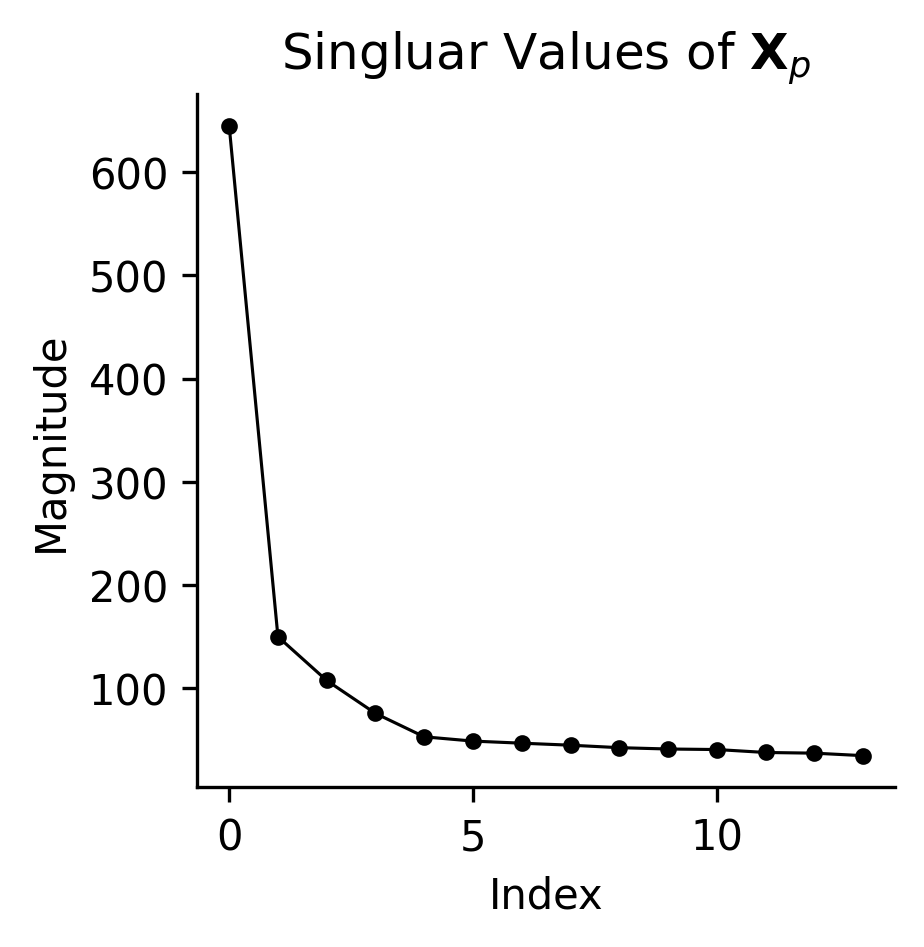

In [40]:
sval = dmd_res['SVD'][1]

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 3
plt.rcParams['figure.facecolor'] = "None"

plt.plot(sval, lw=0.75, c='k', marker=".")
plt.title(r"Singluar Values of $\mathbf{X}_p$")
plt.ylabel(r"Magnitude")
plt.xlabel(r"Index")

print(f"{sval.max()=:.4f} {sval.min()=:.4f}")

# plt.gca().set_facecolor("None")
sns.despine()

pdf.shape=(8, 2)


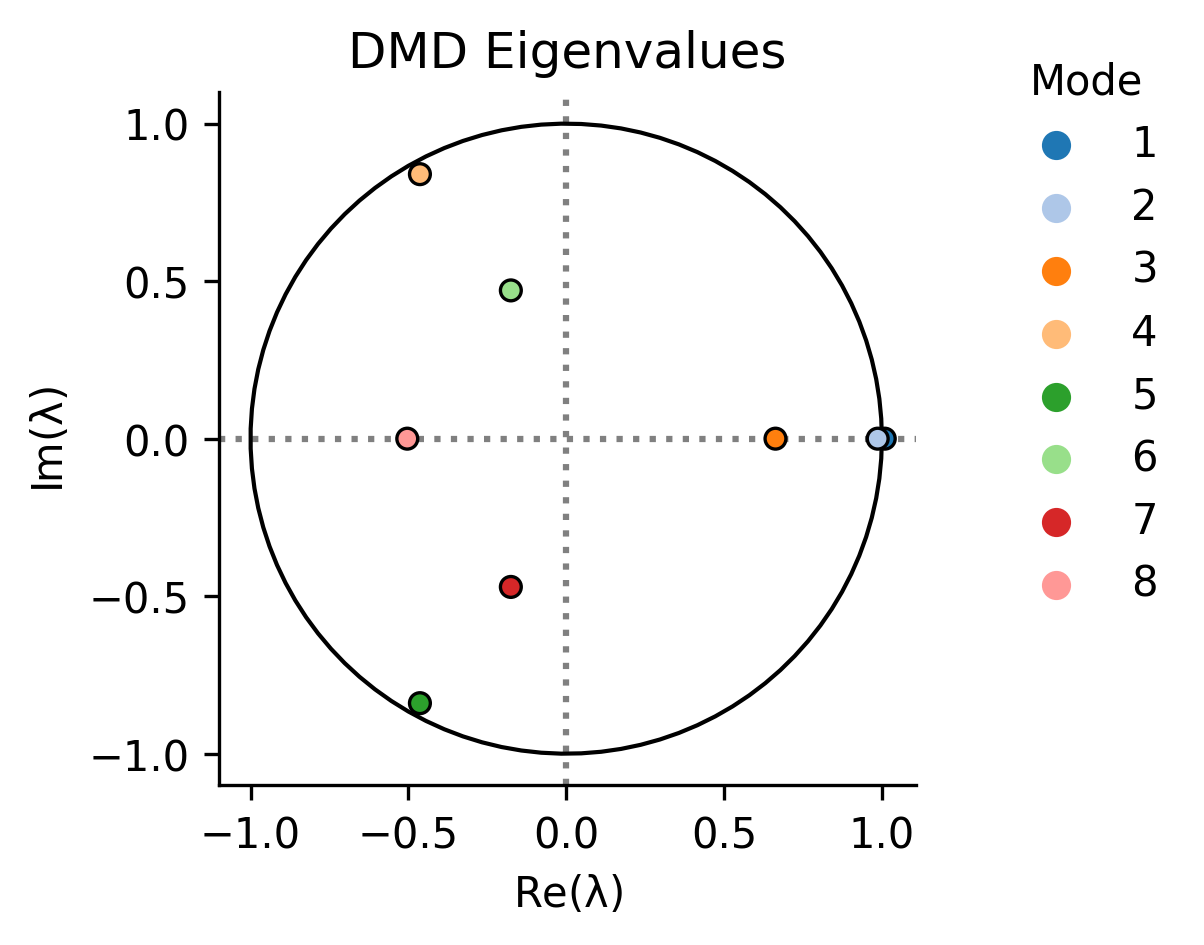

In [41]:
""" Plot DMD eigenvalues  """
t = np.linspace(0, np.pi*2, 100)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 3

L = dmd_res['L']

# make the unit circle
plt.plot(np.cos(t), 
         np.sin(t), 
         linewidth=1, 
         c='k',
         zorder=1)

pdf = pd.DataFrame({'real' : np.real(L),
                    'imaginary' : np.imag(L)})

print(f"{pdf.shape=}")
pdf['mode'] = list(range(1, len(pdf)+1))

# plot the eigenvalues
sns.scatterplot(data=pdf,
                x='real', 
                y='imaginary',
                s=100,
                marker=".",
                # legend=False,
                hue='mode',
                # c='r',
                ec='k',
                palette='tab20',
                zorder=3)

# add the axis
plt.axvline(x=0, ls=":", c='grey', zorder=0)
plt.axhline(y=0, ls=":", c='grey', zorder=0)

plt.axis('equal')
plt.title("DMD Eigenvalues")
plt.xlabel(r'$\mathregular{Re(\lambda)}$')
plt.ylabel(r'$\mathregular{Im(\lambda)}$')

sns.move_legend(plt.gca(), 
                title='Mode',
                frameon=False, 
                loc='upper right',
                bbox_to_anchor=(1.4, 1.1))

sns.despine()

phi.shape=(19393, 8)
pdf.shape=(800, 9)
[ 50. 150. 250. 350. 450. 550. 650. 750. 850.]
['Mode 1', 'Mode 2', 'Mode 3', 'Mode 4', 'Mode 5', 'Mode 6', 'Mode 7', 'Mode 8']


Text(0.5, 110.16666666666664, 'Time (hr)')

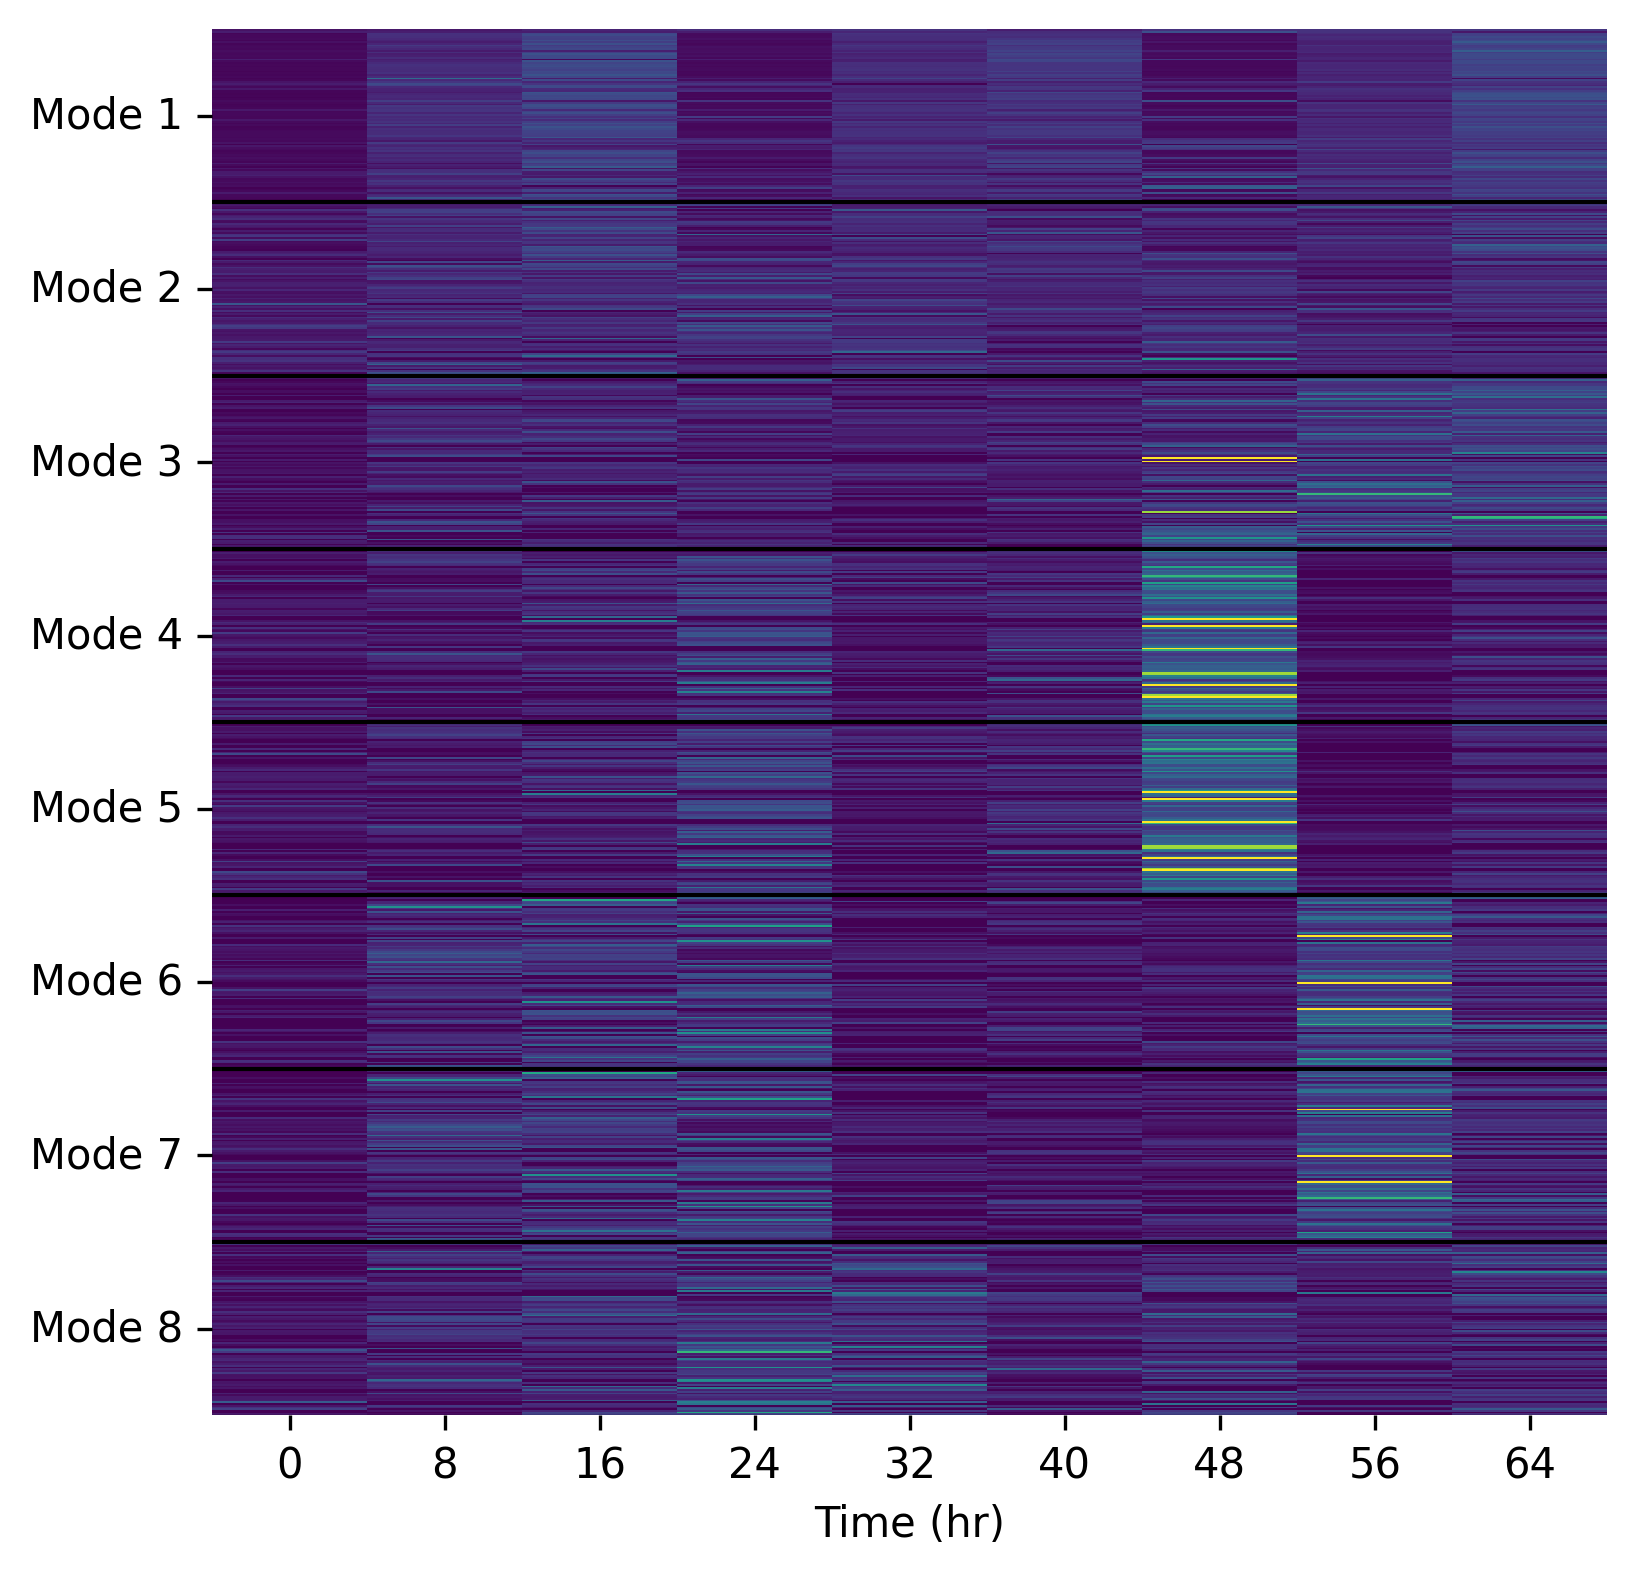

In [77]:
"""
visualize top genes for each mode
"""

top_n = 100

phi = np.real(dmd_res['Phi'])
phi = pd.DataFrame(phi, index=gene_names)
print(f"{phi.shape=}")
phi = phi.rank(ascending=False)

top_genes = []

for c in phi.columns:
    top_genes += phi[phi[c] <= top_n][c].index.to_list()
    
pdf = mu_data[top_genes].T
print(f"{pdf.shape=}")

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 6

sns.heatmap(data=pdf,
            cbar=False,
            cmap='viridis',
            zorder=0)

# plt.yticks([], [])
ax = plt.gca()
# ax.tick_params(axis='y', rotation=0)

ypoints = np.linspace(0, pdf.shape[0] * top_n, pdf.shape[0]).astype(int)
for y in ypoints[1:]:
    plt.axhline(y=y, zorder=2, c='k', lw=1)

yticks =  np.linspace(0, pdf.shape[0], pdf.shape[1]  )
yticks = yticks + (top_n / 2)
yticklabels = [f"Mode {c+1}" for c in phi.columns]
print(yticks)
print(yticklabels)

_ = plt.yticks(yticks[:-1],yticklabels)
plt.ylabel("")

xtickLabels = np.array(range(0, 9)) * 8 # hours between time points
ax.set_xticklabels(xtickLabels)
plt.xlabel("Time (hr)")


# Explore the top genes for each mode

In [89]:
top_n = 100

phi = np.real(dmd_res['Phi'])
phi = pd.DataFrame(phi, index=gene_names)
print(f"{phi.shape=}")
phi = phi.rank(ascending=False)


# db = 'GO_Biological_Process_2023'
db = 'GO_Biological_Process_2021'
# db = 'KEGG_2021_Human'
# db = 'TRANSFAC_and_JASPAR_PWMs'


for c in phi.columns:
    genes = phi[phi[c] <= top_n][c].index.to_list()
    
    enrich = gget.enrichr(genes, database=db)
    pd.set_option('display.max_colwidth', 100)

    print(f"======== Mode {c+1} ========")
    print(enrich[['path_name', 'adj_p_val', 'overlapping_genes']].head(10))
    print()
    time.sleep(5)

    
    # break

Mon Oct 16 09:31:06 2023 INFO Performing Enichr analysis using database GO_Biological_Process_2021.


phi.shape=(19393, 8)
======== Mode 1 ========
                                                                path_name  \
0                               mitotic spindle organization (GO:0007052)   
1  microtubule cytoskeleton organization involved in mitosis (GO:1902850)   
2                       mitotic sister chromatid segregation (GO:0000070)   
3                                        mitotic cytokinesis (GO:0000281)   
4                         cytoskeleton-dependent cytokinesis (GO:0061640)   
5                           regulation of cell cycle process (GO:0010564)   
6                                   mitotic nuclear division (GO:0140014)   
7                               sister chromatid segregation (GO:0000819)   
8                                   mitotic spindle assembly (GO:0090307)   
9                                 mitotic spindle elongation (GO:0000022)   

      adj_p_val  \
0  7.593788e-25   
1  3.511813e-22   
2  2.323333e-14   
3  7.617218e-12   
4  9.225281

Mon Oct 16 09:31:11 2023 INFO Performing Enichr analysis using database GO_Biological_Process_2021.


======== Mode 2 ========
                                                           path_name  \
0  calcium ion-regulated exocytosis of neurotransmitter (GO:0048791)   
1     regulation of non-canonical Wnt signaling pathway (GO:2000050)   
2                         acyl-CoA biosynthetic process (GO:0071616)   
3                               potassium ion transport (GO:0006813)   
4                      regulation of dendrite extension (GO:1903859)   
5                  synaptic transmission, glutamatergic (GO:0035249)   
6                 potassium ion transmembrane transport (GO:0071805)   
7                      fatty-acyl-CoA metabolic process (GO:0035337)   
8                            neurotransmitter transport (GO:0006836)   
9            positive regulation of signal transduction (GO:0009967)   

   adj_p_val                         overlapping_genes  
0   0.330481                            [UNC13A, SYT8]  
1   0.330481                            [TIAM1, SPEF1]  
2   0.33048

Mon Oct 16 09:31:17 2023 INFO Performing Enichr analysis using database GO_Biological_Process_2021.


======== Mode 3 ========
                                                           path_name  \
0              C21-steroid hormone biosynthetic process (GO:0006700)   
1                               potassium ion transport (GO:0006813)   
2                 potassium ion transmembrane transport (GO:0071805)   
3                 C21-steroid hormone metabolic process (GO:0008207)   
4  positive regulation of neuron projection development (GO:0010976)   
5                  steroid hormone biosynthetic process (GO:0120178)   
6                                      cation transport (GO:0006812)   
7                         defense response to bacterium (GO:0042742)   
8                                    protein maturation (GO:0051604)   
9  positive regulation of stress-activated MAPK cascade (GO:0032874)   

   adj_p_val              overlapping_genes  
0   0.260795                [CYP11A1, FDX2]  
1   0.260795  [KCNK9, KCNJ15, KCNN2, KCNA6]  
2   0.260795  [KCNK9, KCNJ15, KCNN2, KCNA6] 

Mon Oct 16 09:31:22 2023 INFO Performing Enichr analysis using database GO_Biological_Process_2021.


======== Mode 4 ========
                                                                              path_name  \
0                                                   epithelium development (GO:0060429)   
1                                               defense response to fungus (GO:0050832)   
2                                        peptidyl-cysteine S-nitrosylation (GO:0018119)   
3                                            defense response to bacterium (GO:0042742)   
4  antimicrobial humoral immune response mediated by antimicrobial peptide (GO:0061844)   
5                          regulation of entry of bacterium into host cell (GO:2000535)   
6                                                    leukocyte aggregation (GO:0070486)   
7                                                       retina homeostasis (GO:0001895)   
8                                                    epidermis development (GO:0008544)   
9                                           peptidyl-cysteine mod

Mon Oct 16 09:31:28 2023 INFO Performing Enichr analysis using database GO_Biological_Process_2021.


======== Mode 5 ========
                                                                              path_name  \
0                                                   epithelium development (GO:0060429)   
1                                               defense response to fungus (GO:0050832)   
2                                        peptidyl-cysteine S-nitrosylation (GO:0018119)   
3                                            defense response to bacterium (GO:0042742)   
4  antimicrobial humoral immune response mediated by antimicrobial peptide (GO:0061844)   
5                          regulation of entry of bacterium into host cell (GO:2000535)   
6                                                    leukocyte aggregation (GO:0070486)   
7                                                       retina homeostasis (GO:0001895)   
8                                                    epidermis development (GO:0008544)   
9                                           peptidyl-cysteine mod

Mon Oct 16 09:31:33 2023 INFO Performing Enichr analysis using database GO_Biological_Process_2021.


======== Mode 6 ========
                                                                                       path_name  \
0                                    positive regulation of mast cell degranulation (GO:0043306)   
1                                                     lipoprotein metabolic process (GO:0042157)   
2                           positive regulation of multicellular organismal process (GO:0051240)   
3                                           regulation of epithelial cell migration (GO:0010632)   
4                                                           dendrite self-avoidance (GO:0070593)   
5                                                        motor neuron axon guidance (GO:0008045)   
6  positive regulation of cyclin-dependent protein serine/threonine kinase activity (GO:0045737)   
7                                                negative regulation of cell growth (GO:0030308)   
8                          negative regulation of T cell receptor signaling

Mon Oct 16 09:31:39 2023 INFO Performing Enichr analysis using database GO_Biological_Process_2021.


======== Mode 7 ========
                                                                                       path_name  \
0                                    positive regulation of mast cell degranulation (GO:0043306)   
1                                                     lipoprotein metabolic process (GO:0042157)   
2                           positive regulation of multicellular organismal process (GO:0051240)   
3                                           regulation of epithelial cell migration (GO:0010632)   
4                                                           dendrite self-avoidance (GO:0070593)   
5                                                        motor neuron axon guidance (GO:0008045)   
6  positive regulation of cyclin-dependent protein serine/threonine kinase activity (GO:0045737)   
7                                                negative regulation of cell growth (GO:0030308)   
8                          negative regulation of T cell receptor signaling

Mon Oct 16 09:31:44 2023 INFO Performing Enichr analysis using database GO_Biological_Process_2021.


======== Mode 8 ========
                                                       path_name  adj_p_val  \
0                          sterol metabolic process (GO:0016125)   0.369249   
1                           cholesterol homeostasis (GO:0042632)   0.369249   
2                                sterol homeostasis (GO:0055092)   0.369249   
3                                cholesterol efflux (GO:0033344)   0.369249   
4              steroid hormone biosynthetic process (GO:0120178)   0.369249   
5                   protein insertion into membrane (GO:0051205)   0.369249   
6  negative regulation of epithelial cell migration (GO:0010633)   0.369249   
7                                  response to cAMP (GO:0051591)   0.369249   
8                       regulation of wound healing (GO:0061041)   0.369249   
9            phosphatidic acid biosynthetic process (GO:0006654)   0.369249   

       overlapping_genes  
0  [FDX2, CYP19A1, TSKU]  
1   [ABCG8, ACSM1, TSKU]  
2   [ABCG8, ACSM1, TSKU]

Correlation: 0.9193
phi.shape=(19393, 8)


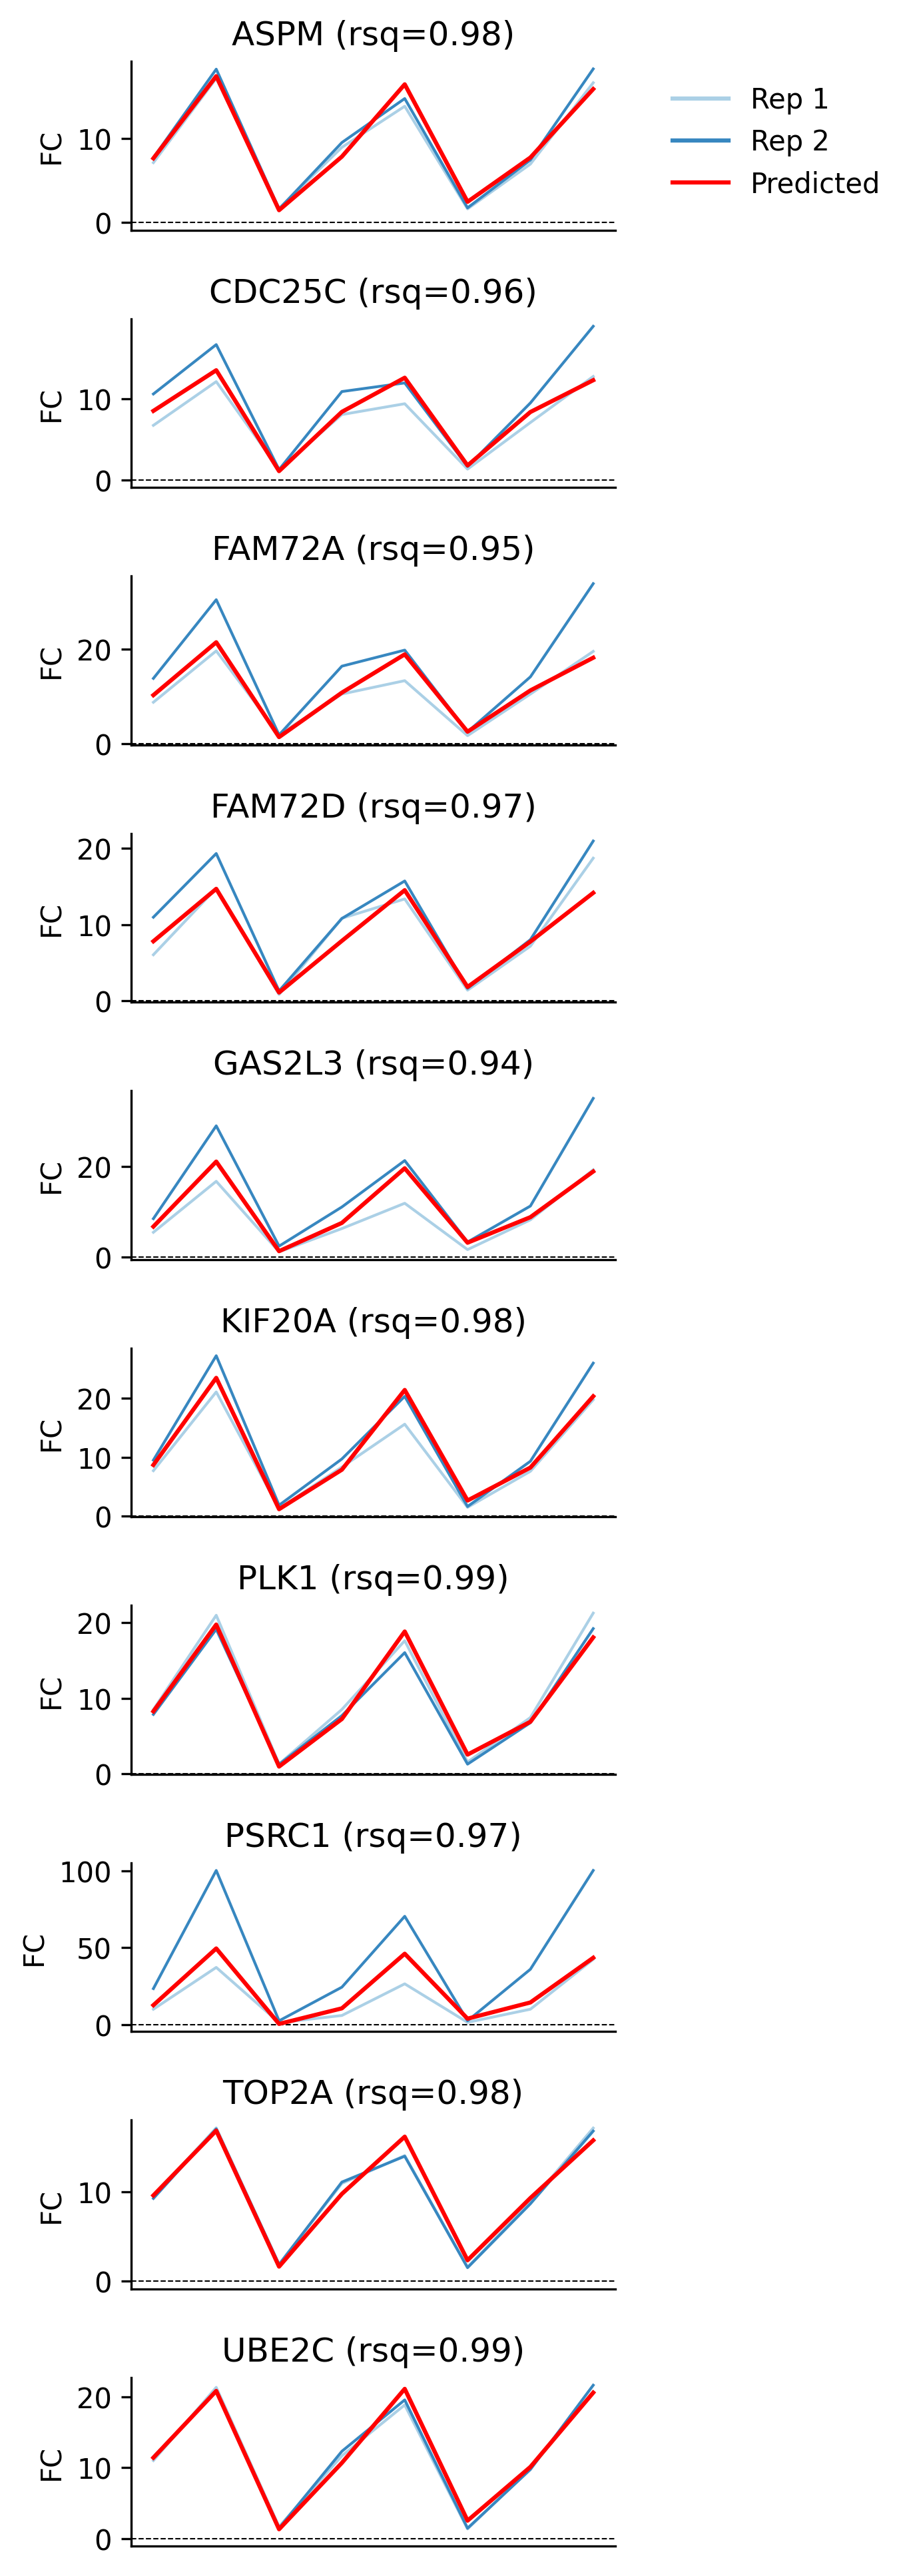

In [93]:
top_n = 10
modes = [0]

X_pred, cd = hasnain_DMD.get_predictions(dmd_res)
print(f"Correlation: {cd:.4f}")

phi = np.real(dmd_res['Phi'])
phi = pd.DataFrame(phi, index=gene_names)
print(f"{phi.shape=}")
phi = phi.rank(ascending=False)

top_genes = []

for c in modes:
    top_genes += phi[phi[c] <= top_n][c].index.to_list()

r_ind = np.array([gene_names.index(x) for x in top_genes])

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 1.3*top_n

fig, axs = plt.subplots(top_n, 1, sharex=True)


for i, g in enumerate(r_ind):

    g_name = top_genes[i]
    actual = dmd_data[g]


    actual = pd.DataFrame(actual, columns=['Rep 1', 'Rep 2'])
    actual['time'] = list(range(0, len(actual)))
    actual = pd.melt(actual, id_vars='time')

    sns.lineplot(data=actual, 
                 x='time',
                 y='value',
                 hue='variable',
                 lw=1,
                 ax=axs[i],
                 palette='Blues')

    act_mean = np.mean(dmd_data[g], axis=1).ravel()
    pred_mean = np.mean(X_pred[g], axis=1).ravel()

    corr, pval = scipy.stats.pearsonr(act_mean, pred_mean)

    axs[i].plot(pred_mean, color='r', label='Predicted')
    axs[i].axhline(y=0, ls="--", lw=0.5, c='k', zorder=0)
    axs[i].legend()

    if i == 0:

        sns.move_legend(axs[i],
                        loc='upper right',
                        title='',
                        bbox_to_anchor=(1.6, 1),
                        frameon=False,)
    else:
        axs[i].legend().remove()
    
    axs[i].set_ylabel("FC")
    # xticks = np.linspace(0, 15, 4)
    # xtickLabels = np.linspace(0, 64, 4).astype(int)
    axs[i].set_xticks([])
    axs[i].set_xticklabels([])
    axs[i].set_xlabel("Time (hr)")
    axs[i].set_title(f"{g_name} (rsq={corr:.2f})")

plt.tight_layout()
sns.despine()

In [94]:
def gram_matrix(A, x0, nT=50, reduced=True, projection_matrix=np.array([])):
    '''
    A: matrix representation of the Koopman operator
    x0: initial conditions from measurements
    nT: number of timepoints over which to compute the Gram matrix
    reduced: if True, will compute reduced G from reduced data and KO and will also return full G after inverse projection
    projection_matrix: the matrix used to project data and KO to low-dimensional space (first r eigenvectors of Data.T @ Data)
    Both A and x0 can be either the full dimensional data and KO or they can be the DMD projected data and KO
    If projected, then return both the projected G and the full G after inverting the projection
    If not projected, then compute full G (can be slow, especially if the data dimension exceeds a couple thousand)
    Furthermore, for sensor placement we need to compute the eigendecomposition of G, so having the reduced G is handy   
    '''
    # generate artificial initial conditions for robust optimization 
    # get the min and max of each gene's initial value
    x0min = np.min(x0, axis=1)
    x0max = np.max(x0, axis=1)
    # form a set of new initial conditions distributed uniformly from x0min to x0max
    numICs = x0.shape[0]
    x0uni = np.zeros((len(x0min),numICs))
    x0uni[:,0:x0.shape[1]] = deepcopy(x0)
    for ii in range(x0.shape[1], x0uni.shape[1]):
        x0tmp = np.random.uniform(x0min,x0max)
        x0uni[:,ii] = x0tmp

    G = np.zeros_like(A)
    for ii in range(nT):
        print(f"{ii}...")
        A_pow = np.linalg.matrix_power(A,ii)
        G += np.matmul( np.matmul(A_pow, x0uni), np.matmul(x0uni.T, A_pow.T) ) 
    # right eigenvectors of G (columns of V) are rows of the gene sampling matrix (or vector if just one eigvec kept)

    if reduced: 
        Gfull = np.matmul(np.matmul(projection_matrix, G), projection_matrix.T)
        return G, Gfull
    else: 
        return G # this is the full G, computed directly from full KO and data


A = dmd_res['Atilde']
u = dmd_res['u_r']
data_embedded = dmd_res['data_embedded']
nT = 8
G, Gfull = gram_matrix(A, data_embedded[:,0,:], nT=nT, reduced=True, projection_matrix=u)
print(f"{G.shape=} {Gfull.shape=}")

0...
1...
2...
3...
4...
5...
6...
7...
G.shape=(8, 8) Gfull.shape=(19393, 19393)


In [95]:
# compute eigendecomposition of the Gram matrices
# right eigenvectors of G (columns of V) are rows of the gene sampling matrix 
D, V = np.linalg.eig(Gfull)
print(f"{D.shape=}{ V.shape=}")

D.shape=(19393,) V.shape=(19393, 19393)


evals.max()=1980713.3441+0.0000j evals.min()=-0.0000-0.0000j


/home/cstansbu/.local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


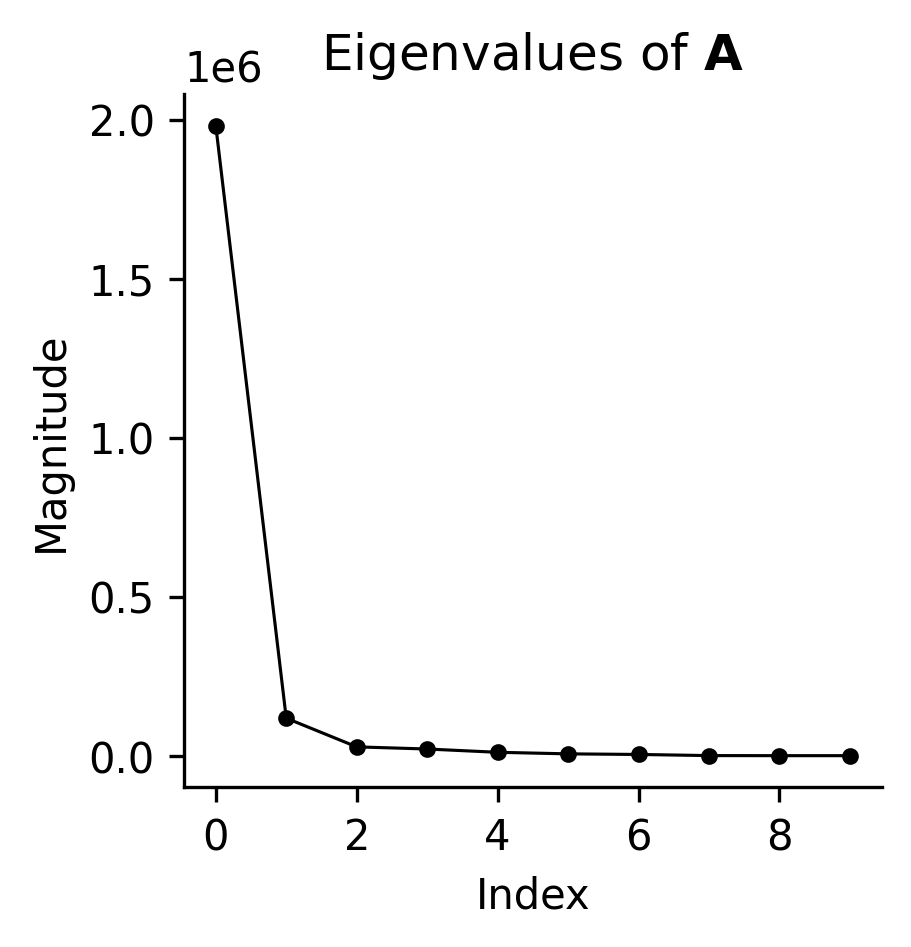

In [96]:
n_val = 10
evals = D[:n_val]

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 3
plt.rcParams['figure.facecolor'] = "None"

plt.plot(evals, lw=0.75, c='k', marker=".")
plt.title(r"Eigenvalues of $\mathbf{A}$")
plt.ylabel(r"Magnitude")
plt.xlabel(r"Index")

print(f"{evals.max()=:.4f} {evals.min()=:.4f}")

# plt.gca().set_facecolor("None")
sns.despine()

In [97]:
obs = pd.DataFrame({'gene' : gene_names,
                    'ev1' : V[:,0],
                    'weight' : np.real(V[:,0])})

obs['rank'] = obs['weight'].rank()
obs = obs.sort_values(by='rank', ascending=False)

obs.head(20)

,gene,ev1,weight,rank
5573,FBXO32,-0.001261+0.000000j,-0.001261,19393.0
4422,DNAJB13,-0.001387+0.000000j,-0.001387,19392.0
4811,EGR4,-0.001453+0.000000j,-0.001453,19391.0
9847,MROH5,-0.001499+0.000000j,-0.001499,19390.0
4507,DOK7,-0.001583+0.000000j,-0.001583,19389.0
1534,BHLHA15,-0.001661+0.000000j,-0.001661,19388.0
12381,PLAC9,-0.001678+0.000000j,-0.001678,19387.0
15506,SNAI1,-0.001831+0.000000j,-0.001831,19386.0
6224,GFPT2,-0.001905+0.000000j,-0.001905,19385.0
12050,PEAK3,-0.001907+0.000000j,-0.001907,19384.0


In [101]:
obs.describe()

,ev1,weight,rank
count,19393000.0+0.0000j,19393.000000,19393.000000
mean,-0.006478+0.000000j,-0.006478,9697.000000
std,0.003099+0.000000j,0.003099,5587.063374
min,-0.142531+0.000000j,-0.142531,1.000000
25%,-0.006940+0.000000j,-0.006940,4849.000000
50%,-0.006009+0.000000j,-0.006009,9674.000000
75%,-0.005609+0.000000j,-0.005609,14545.000000
max,-0.001261+0.000000j,-0.001261,19393.000000


In [103]:
obs.tail(20)

,gene,ev1,weight,rank
752,ANLN,-0.049653+0.000000j,-0.049653,20.0
2641,CDC25C,-0.050419+0.000000j,-0.050419,19.0
5113,ERN2,-0.052227+0.000000j,-0.052227,18.0
5439,FAM72D,-0.052930+0.000000j,-0.052930,17.0
8201,KIF14,-0.053420+0.000000j,-0.053420,16.0
8216,KIF23,-0.054141+0.000000j,-0.054141,15.0
5437,FAM72B,-0.056134+0.000000j,-0.056134,14.0
1338,AURKA,-0.056594+0.000000j,-0.056594,13.0
4220,DEPDC1,-0.057599+0.000000j,-0.057599,12.0
1162,ASPM,-0.058033+0.000000j,-0.058033,11.0


In [104]:
n_gene = 500
# genes = obs['gene'].head(n_gene).to_list()
genes = obs['gene'].tail(n_gene).to_list()

# db = 'GO_Biological_Process_2023'
db = 'GO_Biological_Process_2021'
# db = 'KEGG_2021_Human'
# db = 'TRANSFAC_and_JASPAR_PWMs'

enrich = gget.enrichr(genes, database=db)
pd.set_option('display.max_colwidth', 100)
enrich[['path_name', 'adj_p_val', 'overlapping_genes']].head(20)

Mon Oct 16 10:36:53 2023 INFO Performing Enichr analysis using database GO_Biological_Process_2021.


,path_name,adj_p_val,overlapping_genes
0,microtubule cytoskeleton organization involved in mitosis (GO:1902850),4.959996e-39,"[GPSM2, ERCC6L, BUB1B, CDCA8, TTK, KIF11, CENPA, SKA1, AURKB, SKA2, AURKA, CDC20, CCNB1, STMN1, ..."
1,mitotic spindle organization (GO:0007052),1.985727e-38,"[GPSM2, ERCC6L, BUB1B, KIF11, CDC20, STMN1, NUF2, SPDL1, DLGAP5, KIF23, KNL1, RANGAP1, CKAP5, SG..."
2,mitotic sister chromatid segregation (GO:0000070),9.890586e-28,"[CDCA5, NCAPG2, KIF14, CDCA8, NCAPG, SMC4, NCAPH, SMC2, CCNB1, RAD21, NUSAP1, SPDL1, CEP55, DLGA..."
3,sister chromatid segregation (GO:0000819),3.678289e-16,"[TOP2A, SPAG5, NCAPG2, PLK1, CDCA8, SMC4, KNSTRN, NDC80, ZWINT, SGO1, SGO2, KIF18A, KIF18B, ESPL..."
4,mitotic cell cycle phase transition (GO:0044772),1.259608e-15,"[CCNF, FOXM1, AURKA, CCNB3, CCNB2, CCNB1, TUBA1A, CDC27, CEP70, NEK2, PLK4, CDKN2D, CDKN2C, BORA..."
5,mitotic nuclear division (GO:0140014),1.376887e-15,"[SPAG5, UBE2C, NCAPG2, PLK1, CDCA8, KIF11, SMC4, KNSTRN, MZT1, NDC80, ZWINT, SGO1, SGO2, TPX2, K..."
6,positive regulation of cell cycle process (GO:0090068),1.597381e-12,"[GEN1, PLK4, GPSM2, SPAG5, EGF, KIF14, KIF23, DBF4B, NDC80, AURKB, CDC25B, CIT, AURKA, CCNB1, DB..."
7,chromosome condensation (GO:0030261),1.597381e-12,"[TOP2A, CDCA5, NCAPG2, PLK1, NCAPG, SMC4, H1-0, NCAPH, SMC2, H1-5, ERN2, CCNB1, INCENP, NUSAP1, ..."
8,mitotic cytokinesis (GO:0000281),6.377272e-12,"[PLK1, CKAP2, KIF23, CENPA, CIT, ANLN, ESPL1, RACGAP1, INCENP, KIF4B, KIF4A, STMN1, NUSAP1, KIF2..."
9,regulation of mitotic cell cycle phase transition (GO:1901990),6.377272e-12,"[KIF14, BUB1B, HMMR, AURKA, CDC20, CCNB1, TUBA1A, CDC27, CEP70, NEK2, BUB3, PLK4, ODF2, UBE2C, T..."


In [106]:
kid = "hsa04110"
pway_genes = ut.parseKEGG(kid)
len(pway_genes)

157

In [117]:
top = 500
observables = obs['gene'].tail(top).to_list()
hits = [x for x in observables if x in pway_genes]
print(len(hits))

32
